In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_squared_log_error
import mlflow
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import itertools

In [3]:
# load data -> split into train and test. -> convert caltgoraicl columns into taget encoding

processed_data = pd.read_csv('../data/processed/processed_data.csv')

cat_cols = ['market_id', 'store_primary_category','order_protocol']

num_cols = ['total_items','subtotal', 'num_distinct_items', 'min_item_price','max_item_price',
            'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', ]

creatred_numcols = ['day_of_week', 'week_of_year', 'hour_of_day', 'minute_of_hour', 
                    'is_holiday', 'is_weekend','is_long_weekend']

target_col = 'delivery_duration'

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    processed_data.drop(columns=[target_col]),
    processed_data[target_col],
    test_size=0.2,
    random_state=42
)


te = TargetEncoder(cols=cat_cols)
X_train_enc = te.fit_transform(X_train, y_train)
X_test_enc = te.transform(X_test)




In [5]:
# drop unnecessary columns
drop_cols = set(X_train_enc.columns) - set(num_cols) - set(creatred_numcols) - {target_col} - set(cat_cols)

print("Dropping columns:", drop_cols)

X_train_final = X_train_enc.drop(columns=drop_cols)
X_test_final = X_test_enc.drop(columns=drop_cols)

Dropping columns: {'actual_delivery_time', 'created_at'}


In [6]:

# -------- Feature scaling --------
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train_final)
X_test_scaled = X_scaler.transform(X_test_final)

# -------- Target scaling (ONLY if needed, e.g. NN) --------
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(
    y_train.values.reshape(-1, 1)
).ravel()

y_test_scaled = y_scaler.transform(
    y_test.values.reshape(-1, 1)
).ravel()




In [7]:
# Base line model -> Linear Regression
# ML model using XGBoost
# NN model using TensorFlow/Keras

In [10]:
# model 1 - Linear Regression


mlflow.set_tracking_uri("/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/mlruns")
mlflow.set_experiment("delivery_time_prediction")



with mlflow.start_run(run_name="Linear_Regression_Model"):
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train_scaled)
    y_pred_train = lr_model.predict(X_train_scaled)
    y_pred_test = lr_model.predict(X_test_scaled)

    y_pred_train = y_scaler.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
    y_pred_test = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()
    

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    train_rmse = mean_squared_error(y_train, y_pred_train)
    test_rmse = mean_squared_error(y_test, y_pred_test)

    print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

    # log parameters and metrics to mlflow
    mlflow.log_param("model_type", "Linear Regression")
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)

    # log the model
    mlflow.sklearn.log_model(lr_model, "linear_regression_model")


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2025/12/26 00:08:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train MAE: 2.1234812129742844, Test MAE: 2.098722711995327
Train RMSE: 9.08437942941441, Test RMSE: 8.733328064668026


In [ ]:
# add atree based model here

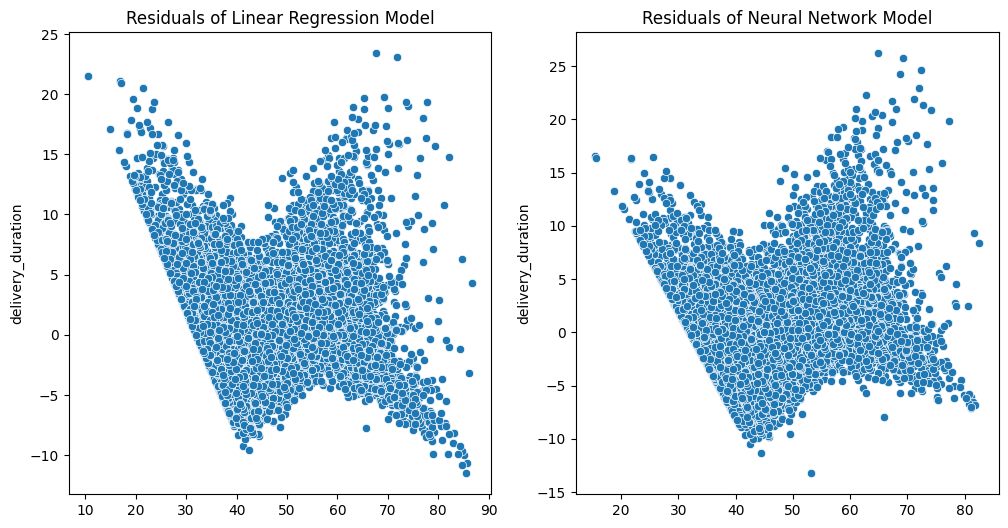

In [19]:
# check residuals of both linear regression and nn model
residuals_lr = y_test - y_pred_test
residuals_nn = y_test - y_pred_test_nn

# plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test, y=residuals_lr)
plt.title('Residuals of Linear Regression Model')   
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_test_nn, y=residuals_nn)
plt.title('Residuals of Neural Network Model')
plt.show()


# heteroscedasticity -> where residuals are in butterfly shape

“Residual analysis showed strong heteroscedasticity but limited non-linearity in the mean. This explains why linear regression outperformed neural networks. The appropriate next step is target transformation or tree-based models rather than increasing NN complexity.”

In [21]:
# step 1 -> add log transforamtion to target variable

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# run both models again with log transformed target variable

# linear model


with mlflow.start_run(run_name="Linear_Regression_Model_Log_Target"):
    lr_model_log = LinearRegression()
    lr_model_log.fit(X_train_scaled, y_train_log)
    y_pred_train_log = lr_model_log.predict(X_train_scaled)
    y_pred_test_log = lr_model_log.predict(X_test_scaled)

    y_pred_train_log = np.expm1(y_pred_train_log)
    y_pred_test_log = np.expm1(y_pred_test_log)
    

    train_mae_log = mean_absolute_error(y_train, y_pred_train_log)
    test_mae_log = mean_absolute_error(y_test, y_pred_test_log)

    train_rmse_log = mean_squared_error(y_train, y_pred_train_log)
    test_rmse_log = mean_squared_error(y_test, y_pred_test_log)

    print(f"Log Target - Train MAE: {train_mae_log}, Test MAE: {test_mae_log}")
    print(f"Log Target - Train RMSE: {train_rmse_log}, Test RMSE: {test_rmse_log}")

    # log parameters and metrics to mlflow
    mlflow.log_param("model_type", "Linear Regression with Log Target")
    mlflow.log_metric("train_mae", train_mae_log)
    mlflow.log_metric("test_mae", test_mae_log)
    mlflow.log_metric("train_rmse", train_rmse_log)
    mlflow.log_metric("test_rmse", test_rmse_log)

    # log the model
    mlflow.sklearn.log_model(lr_model_log, "linear_regression_model_log_target")





2025/12/26 00:58:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Log Target - Train MAE: 2.106684593192709, Test MAE: 2.072298456875822
Log Target - Train RMSE: 9.192998663877551, Test RMSE: 8.72419152279872


# Hyperparameter tuning for the NN model

In [91]:


def build_nn_model_hp(input_dim,
                      neurons=[24,32],
                      dropout_rate=0.2,
                      use_batchnorm=True,
                      learning_rate=1e-3, loss ='mse'):

    model = Sequential()

    # Input layer
    model.add(Dense(neurons[0], activation='relu', input_dim=input_dim))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Hidden layers
    for n in neurons[1:]:
        model.add(Dense(n, activation='relu'))
        if use_batchnorm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer (log target → linear)
    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=['mae']
    )

    return model


In [42]:
import itertools
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error


In [43]:
param_grid = {
    "neurons": [
        [24, 32],
        [16, 32],
        [24, 16]
    ],
    "dropout_rate": [0.1, 0.2, 0.3],
    "use_batchnorm": [True, False],
    "batch_size": [256, 512],
    "learning_rate": [1e-3, 5e-4]
}


In [44]:


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

best_test_rmse = np.inf
best_run_id = None

for params in itertools.product(
        param_grid["neurons"],
        param_grid["dropout_rate"],
        param_grid["use_batchnorm"],
        param_grid["batch_size"],
        param_grid["learning_rate"]):

    neurons, dropout_rate, use_batchnorm, batch_size, lr = params

    with mlflow.start_run(run_name="NN_LogTarget_HP"):
        log_dir = "tb_logs/nn/" + neurons.__str__() + "_" + str(dropout_rate) + "_" + str(use_batchnorm) + "_" + str(batch_size) + "_" + str(lr)
        os.makedirs(log_dir, exist_ok=True)

        tensorboard_cb = TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )

        mlflow.log_params({
            "neurons": str(neurons),
            "dropout_rate": dropout_rate,
            "batchnorm": use_batchnorm,
            "batch_size": batch_size,
            "learning_rate": lr,
            "target_transform": "log1p"
        })

        model = build_nn_model_hp(
            input_dim=X_train_scaled.shape[1],
            neurons=neurons,
            dropout_rate=dropout_rate,
            use_batchnorm=use_batchnorm,
            learning_rate=lr
        )

        history = model.fit(
            X_train_scaled, y_train_log,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop, tensorboard_cb],
            verbose=0
        )

        # Predictions (inverse log)
        y_train_pred = np.expm1(model.predict(X_train_scaled)).ravel()
        y_test_pred = np.expm1(model.predict(X_test_scaled)).ravel()

        # Metrics
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        train_rmse = mean_squared_error(y_train, y_train_pred)
        test_rmse = mean_squared_error(y_test, y_test_pred)

        if (y_test_pred.min() < 0) and (y_train_pred.min() < 0):
            print("Negative predictions encountered; skipping MSLE calculation.")
            train_msle = np.nan
            test_msle = np.nan
        else:   

            train_msle = mean_squared_log_error(y_train, y_train_pred)
            test_msle = mean_squared_log_error(y_test, y_test_pred)

        mlflow.log_metrics({
            "train_mae": train_mae,
            "test_mae": test_mae,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_msle": train_msle,
            "test_msle": test_msle
        })

        # Save best model
        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_run_id = mlflow.active_run().info.run_id
            mlflow.tensorflow.log_model(model, "best_nn_log_target")


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


2025/12/27 14:16:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/27 14:16:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 995us/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step  
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 998us/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1000us/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1000us/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 191s 43ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 929s 211ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative predictions encountered; skipping MSLE calculation.


In [45]:
best_run_id

'f0e920c3b80d42049bfce01ec263087a'

In [86]:
# rank all the models

import os
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def read_tensor_scalar(ea, tag):
    return np.array([
        tf.make_ndarray(e.tensor_proto).item()
        for e in ea.Tensors(tag)
    ])

def read_tb_scalars(run_dir):
    ea_train = EventAccumulator(run_dir + '/train/')
    ea_val = EventAccumulator(run_dir + '/validation/')
    ea_train.Reload()
    ea_val.Reload()

    train_loss = read_tensor_scalar(ea_train, 'epoch_loss')
    val_loss = read_tensor_scalar(ea_val, 'epoch_loss')
    return train_loss, val_loss


def evaluate_run(run_dir, model_params,
                 alpha=0.1, beta=0.1):

    train_loss, val_loss = read_tb_scalars(run_dir)

    best_epoch = np.argmin(val_loss)
    best_val = val_loss[best_epoch]
    train_at_best = train_loss[best_epoch]

    # Generalization gap
    gap = abs(best_val - train_at_best)

    # Stability (±3 epochs around best)
    start = max(0, best_epoch - 3)
    end = min(len(val_loss), best_epoch + 4)
    stability = np.std(val_loss[start:end])

    # Final score
    score = (
        best_val
        + alpha * gap
        + beta * stability
        #+ gamma * np.log(num_params)
    )

    return {
        "run": os.path.basename(run_dir),
        "best_val_loss": best_val,
        "gap": gap,
        "stability": stability,
        "model_params": model_params,
        "score": score
    }



all_ranks = []

for params in itertools.product(
        param_grid["neurons"],
        param_grid["dropout_rate"],
        param_grid["use_batchnorm"],
        param_grid["batch_size"],
        param_grid["learning_rate"]):

    neurons, dropout_rate, use_batchnorm, batch_size, lr = params

    log_dir = "tb_logs/nn/" + neurons.__str__() + "_" + str(dropout_rate) + "_" + str(use_batchnorm) + "_" + str(batch_size) + "_" + str(lr)
    if os.path.exists(log_dir):
        eval_metrics = evaluate_run(
            log_dir,
            model_params={
                "neurons": neurons,
                "dropout_rate": dropout_rate,
                "use_batchnorm": use_batchnorm,
                "batch_size": batch_size,
                "learning_rate": lr
            }
        )
        all_ranks.append(eval_metrics)



import pandas as pd
ranked_df = pd.DataFrame(all_ranks)
ranked_df.head(10)
    




,run,best_val_loss,gap,stability,model_params,score
0,"[24, 32]_0.1_True_256_0.001",0.004015,0.008800,0.000183,"{'neurons': [24, 32], 'dropout_rate': 0.1, 'us...",0.004914
1,"[24, 32]_0.1_True_256_0.0005",0.011507,0.219008,0.004719,"{'neurons': [24, 32], 'dropout_rate': 0.1, 'us...",0.033880
2,"[24, 32]_0.1_True_512_0.001",0.010724,0.210763,0.005735,"{'neurons': [24, 32], 'dropout_rate': 0.1, 'us...",0.032374
3,"[24, 32]_0.1_True_512_0.0005",0.020324,0.412919,0.372538,"{'neurons': [24, 32], 'dropout_rate': 0.1, 'us...",0.098870
4,"[24, 32]_0.1_False_256_0.001",0.022441,0.177996,0.013759,"{'neurons': [24, 32], 'dropout_rate': 0.1, 'us...",0.041617
5,"[24, 32]_0.1_False_256_0.0005",0.020129,0.196031,0.084566,"{'neurons': [24, 32], 'dropout_rate': 0.1, 'us...",0.048189
6,"[24, 32]_0.1_False_512_0.001",0.037197,0.213530,0.014243,"{'neurons': [24, 32], 'dropout_rate': 0.1, 'us...",0.059974
7,"[24, 32]_0.1_False_512_0.0005",0.159118,1.081140,0.392446,"{'neurons': [24, 32], 'dropout_rate': 0.1, 'us...",0.306477
8,"[24, 32]_0.2_True_256_0.001",0.012231,0.127186,0.002438,"{'neurons': [24, 32], 'dropout_rate': 0.2, 'us...",0.025194
9,"[24, 32]_0.2_True_256_0.0005",0.019710,0.308722,0.007916,"{'neurons': [24, 32], 'dropout_rate': 0.2, 'us...",0.051374


In [89]:
ranked_df.loc[0,'model_params']

{'neurons': [24, 32],
 'dropout_rate': 0.1,
 'use_batchnorm': True,
 'batch_size': 256,
 'learning_rate': 0.001}

In [90]:
print("This is the best model parameters: ", ranked_df.loc[0,'model_params'])

This is the best model parameters:  {'neurons': [24, 32], 'dropout_rate': 0.1, 'use_batchnorm': True, 'batch_size': 256, 'learning_rate': 0.001}


In [ ]:
# save oveall model 

best_model_params = ranked_df.loc[0,'model_params']
final_model = build_nn_model_hp(
    input_dim=X_train_scaled.shape[1],
    neurons=best_model_params['neurons'],
    dropout_rate=best_model_params['dropout_rate'],
    use_batchnorm=best_model_params['use_batchnorm'],
    learning_rate=best_model_params['learning_rate']
)

final_model.fit(
    X_train_scaled, y_train_log,
    epochs=100,
    batch_size=best_model_params['batch_size'],
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

mlflow.tensorflow.log_model(final_model, "final_nn_log_target_model")



# one last check use random forest (Tree Based method)


# add one more nn experiment


In [94]:
# instead of mse loss -> let us try loss=tf.keras.losses.Huber(delta=5.0)

huber_loss = tf.keras.losses.Huber(delta=5.0)

huber_model = build_nn_model_hp(
    input_dim=X_train_scaled.shape[1],
    neurons=best_model_params['neurons'],
    dropout_rate=best_model_params['dropout_rate'],
    use_batchnorm=best_model_params['use_batchnorm'],
    learning_rate=best_model_params['learning_rate'],
    loss=huber_loss
)

huber_model.fit(
    X_train_scaled, y_train_log,
    epochs=100,
    batch_size=best_model_params['batch_size'],
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

mlflow.tensorflow.log_model(huber_model, "final_nn_log_target_huber_model")




Epoch 1/100


/Users/pramodkumar/ML Learning/SCALAR/Business Case Studies/NN_Regression_Porter/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 2.1207 - mae: 1.5962 - val_loss: 0.0107 - val_mae: 0.1189
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2001 - mae: 0.4713 - val_loss: 0.0072 - val_mae: 0.0955
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1124 - mae: 0.3599 - val_loss: 0.0058 - val_mae: 0.0857
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0699 - mae: 0.2881 - val_loss: 0.0050 - val_mae: 0.0804
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0492 - mae: 0.2448 - val_loss: 0.0043 - val_mae: 0.0739


2026/01/05 07:23:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 07:23:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [96]:
# get huber model metrics and compare with previous models
y_train_pred_huber = np.expm1(huber_model.predict(X_train_scaled)).ravel()
y_test_pred_huber = np.expm1(huber_model.predict(X_test_scaled)).ravel()
train_mae_huber = mean_absolute_error(y_train, y_train_pred_huber)
test_mae_huber = mean_absolute_error(y_test, y_test_pred_huber)
train_rmse_huber = mean_squared_error(y_train, y_train_pred_huber)
test_rmse_huber = mean_squared_error(y_test, y_test_pred_huber)

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear Regression (Log Target)', 'NN Huber (Log Target)'],
    'Train MAE': [train_mae, train_mae_log, train_mae_huber],
    'Test MAE': [test_mae, test_mae_log, test_mae_huber],
    'Train RMSE': [train_rmse, train_rmse_log, train_rmse_huber],
    'Test RMSE': [test_rmse, test_rmse_log, test_rmse_huber]   
})

comparison_df

4393/4393 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,Model,Train MAE,Test MAE,Train RMSE,Test RMSE
0,Linear Regression,43.690832,43.628023,1986.216279,1977.570743
1,Linear Regression (Log Target),2.106685,2.072298,9.192999,8.724192
2,NN Huber (Log Target),5.515162,5.456572,50.193807,48.311407
